In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import os
import sys
import bilby
import seaborn as sns
import pandas as pd
%matplotlib notebook
import matplotlib as mpl

In [2]:
telescope='MeerKAT'
#telescope='Parkes'

if telescope=='MeerKAT':
    os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')
    Total_chn=29
    residuals_32p_Entire_data = np.genfromtxt('PostRes_32pulint_Entire_NoBadObs_ChnRmd_all.txt')
    residuals_32p_SysNoise_Entire_data = np.genfromtxt('PostRes_32pulint_Entire_NoBadObs_ChnRmd_SysNoise.txt')

if telescope=='Parkes':
    os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_UWL_01Aug_22/Processed/phase_shifted/timfiles')
    Total_chn=35
    residuals_32p_Entire_data = np.genfromtxt('PostRes_64pulint_Entire_SelChn_all.txt')
    residuals_32p_SysNoise_Entire_data = np.genfromtxt('PostRes_64pulint_Entire_SelChn_all_SysNoise.txt')

residuals_32p_Entire_data = residuals_32p_Entire_data.reshape((-1,Total_chn,4)) 

residuals_32p_Entire=residuals_32p_Entire_data[:,:,2]
Freq_32p_Entire=np.mean(residuals_32p_Entire_data[:,:,1],axis=0)

residuals_32p_SysNoise_Entire_data = residuals_32p_SysNoise_Entire_data.reshape((-1,Total_chn,4))

residuals_32p_SysNoise_Entire=residuals_32p_SysNoise_Entire_data[:,:,2]
Freq_32p_SysNoise_Entire=np.mean(residuals_32p_SysNoise_Entire_data[:,:,1],axis=0)



<IPython.core.display.Javascript object>


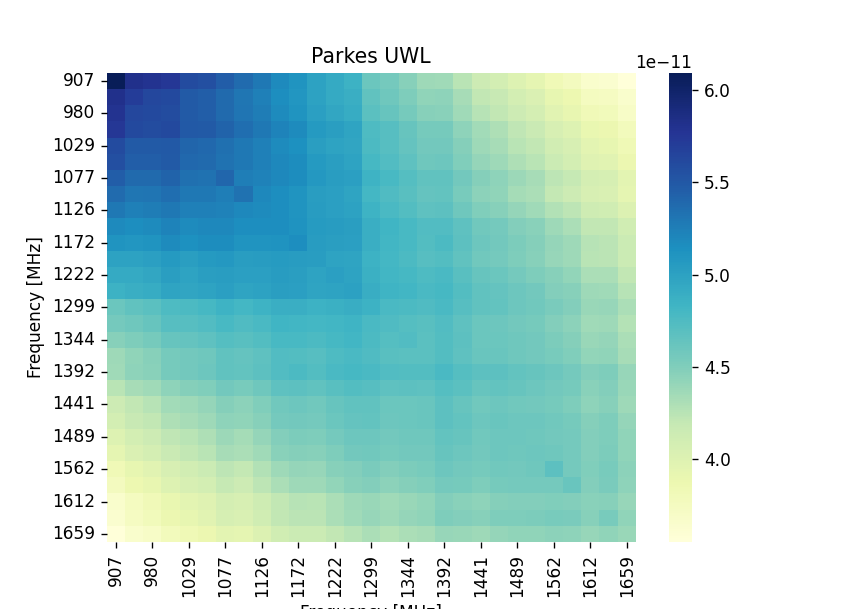

Text(0.5, 1.0, 'Parkes UWL')

In [3]:
Cov_res_32p_Entire=np.cov(residuals_32p_Entire,rowvar=False)
Cov_sysres_32p_Entire=np.cov(residuals_32p_SysNoise_Entire,rowvar=False)

Cov_jitter_32p_Entire=Cov_res_32p_Entire-Cov_sysres_32p_Entire

df=pd.DataFrame(data=Cov_jitter_32p_Entire,
               index=[int(Freq_32p_Entire[i]) for i in range(Freq_32p_Entire.shape[0])],
               columns=[int(Freq_32p_Entire[i]) for i in range(Freq_32p_Entire.shape[0])])
Fig, Ax = plt.subplots(figsize=(7,5))
sns.heatmap(df,ax=Ax,xticklabels=2,cmap='YlGnBu')
Ax.set_xlabel("Frequency [MHz]")
Ax.set_ylabel("Frequency [MHz]")
Ax.set_title('Parkes UWL')

In [61]:
var_jitter_32p_Entire=[]
for chn in range(Cov_jitter_32p_Entire.shape[0]):
    var_jitter_32p_Entire.append(Cov_jitter_32p_Entire[chn,chn])


<IPython.core.display.Javascript object>


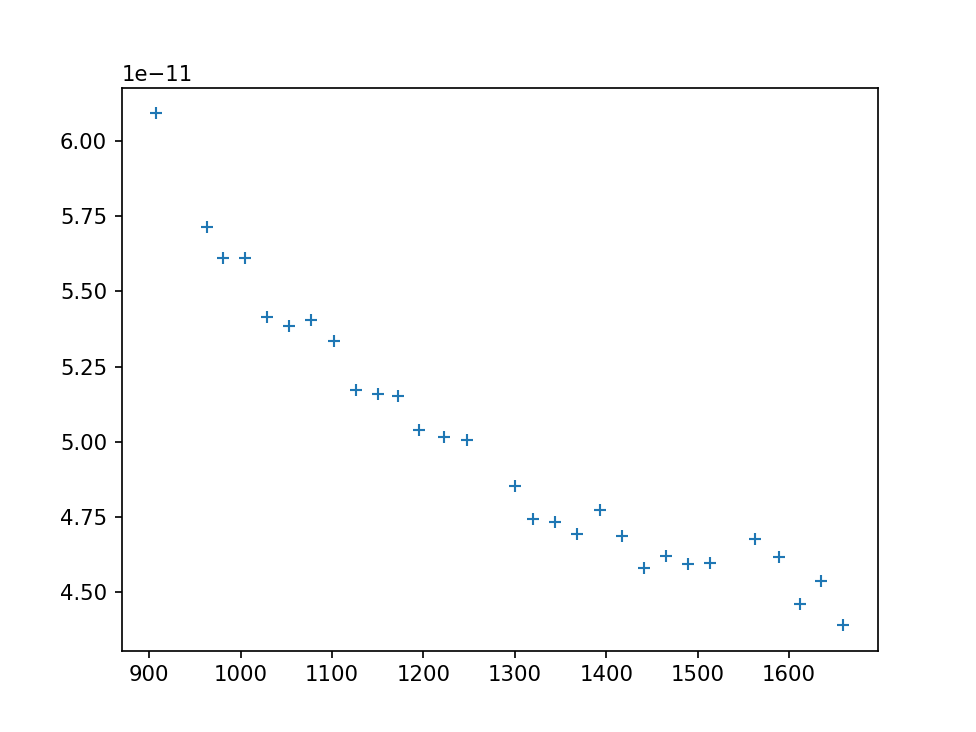

In [62]:
plt.figure()
plt.plot(Freq_32p_Entire,(var_jitter_32p_Entire),'+')

Reading modulation index from the pulse energies computation.
And matching the frequency values from two different datasets.

In [63]:
import psrchive as psr
######## Getting Frequency Values ##############
if telescope=='Parkes':
    os.chdir("/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_UWL_01Aug_22/Processed/phase_shifted")#/32PulInt")
if telescope=='MeerKAT':
    os.chdir("/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/Frequency_Appended_all_withK/Corrected_DM")#/32pul_Integrated")
ar=psr.Archive_load("SinglePulses_5000.ar")
ar.tscrunch()
Freq=ar.get_frequencies()
P=0.00575

data=ar.get_data()
weights=ar.get_weights()
count=0
list_remove_chn=[]
list_keep_chn=[]

if telescope=='Parkes':
    manually_flagged=[1,3,6,20,32,39,42,49,51,52,53,54,56,57,58,59,60,61,62,63]+[2,7,8]  ## Second list contains uneven noise floor
if telescope=='MeerKAT':
    manually_flagged=[1,15,26]+[2,7,8] ## Second list contains uneven floor channels

manually_flagged.sort()

for chn in range(weights.shape[1]):
    for obs in range(weights.shape[0]):
        if (weights[obs,chn]==0):
            count += 1
    if (count > (data.shape[0])/2 or (chn in manually_flagged)):
        list_remove_chn.append(chn)
    else:
        list_keep_chn.append(chn)
    count=0
Freq=np.delete(Freq,list_remove_chn)

In [64]:
from scipy.integrate import quad

def log_normal_mu(x,mu_ln,sigma_ln):
    return x*(1/(x*sigma_ln*np.sqrt(2*np.pi)))*(np.exp((-1/(2*sigma_ln**2))*(np.log(x)-mu_ln)**2))

def log_normal_std(x,mu_ln,sigma_ln):
    return ((x-quad(log_normal_mu, 0.001, np.inf, args=(mu_ln,sigma_ln))[0])**2)*(1/(x*sigma_ln*np.sqrt(2*np.pi)))*(np.exp((-1/(2*sigma_ln**2))*(np.log(x)-mu_ln)**2))


mu=[];sigma=[]

if telescope=='MeerKAT':
    outdir='/home/akulkarn/notebooks/bibly_results_Energy_Dist/MeerKAT_SinglePulse'
    cmd="ls /home/akulkarn/notebooks/bibly_results_Energy_Dist/MeerKAT_SinglePulse | grep 'Chn' | wc -l"
if telescope=='Parkes':
    outdir='/home/akulkarn/notebooks/bibly_results_Energy_Dist_Gaussian/UWL_SinglePulse_Gaussian/'
    cmd="ls /home/akulkarn/notebooks/bibly_results_Energy_Dist_Gaussian/UWL_SinglePulse_Gaussian/ | grep 'Chn' | wc -l"

for chn in range(int(os.popen(cmd).read().strip('\n'))):
    if telescope=='Parkes' and chn in [15,19,24]:
        mu.append(np.nan)
        sigma.append(np.nan)
    else:
        result = bilby.result.read_in_result(outdir=os.path.join(outdir,'Chn_'+str(chn)), label='label')
        mu.append(np.median(result.posterior['mu_ln'].values))
        sigma.append(np.median(result.posterior['sigma_ln'].values))
mu=np.array(mu)
sigma=np.array(sigma)
mod_index_Energies=[]
mu_energy=[]
std_energy=[]
for m, s in zip(mu,sigma):
    mu_energy_temp = quad(log_normal_mu, 0.001, np.inf, args=(m,s))
    mu_energy.append(mu_energy_temp[0])
    std_energy_temp = np.sqrt(quad(log_normal_std, 0.001, np.inf, args=(m,s)))
    std_energy.append(std_energy_temp[0])
    mod_index_Energies.append(std_energy_temp[0]/mu_energy_temp[0])



Removing Channels whose frequencies do not match

In [65]:
rm =[]
for f in Freq_32p_Entire:
    tmp=Freq-f
    if (np.abs(tmp)<10).any():
        continue
    else:
        rm.append(f)
rm_chn=np.where(np.in1d(Freq_32p_Entire,rm))[0]
Freq_32p_Entire_rm=np.delete(Freq_32p_Entire,rm_chn)
var_jitter_32p_Entire_rm=np.delete(var_jitter_32p_Entire,rm_chn)

if telescope=='Parkes':
    Freq_32p_Entire_rm=np.delete(Freq_32p_Entire_rm,[15,19,24])
    var_jitter_32p_Entire_rm=np.delete(var_jitter_32p_Entire_rm,[15,19,24])

Equating jitter noise variance with the modulation index and inferring the phase jitter

Following equation is used:
$$ \delta t = \frac{1}{\sqrt{N_{i}}(1+m_{I}^2)^{1/2}P $$

<IPython.core.display.Javascript object>


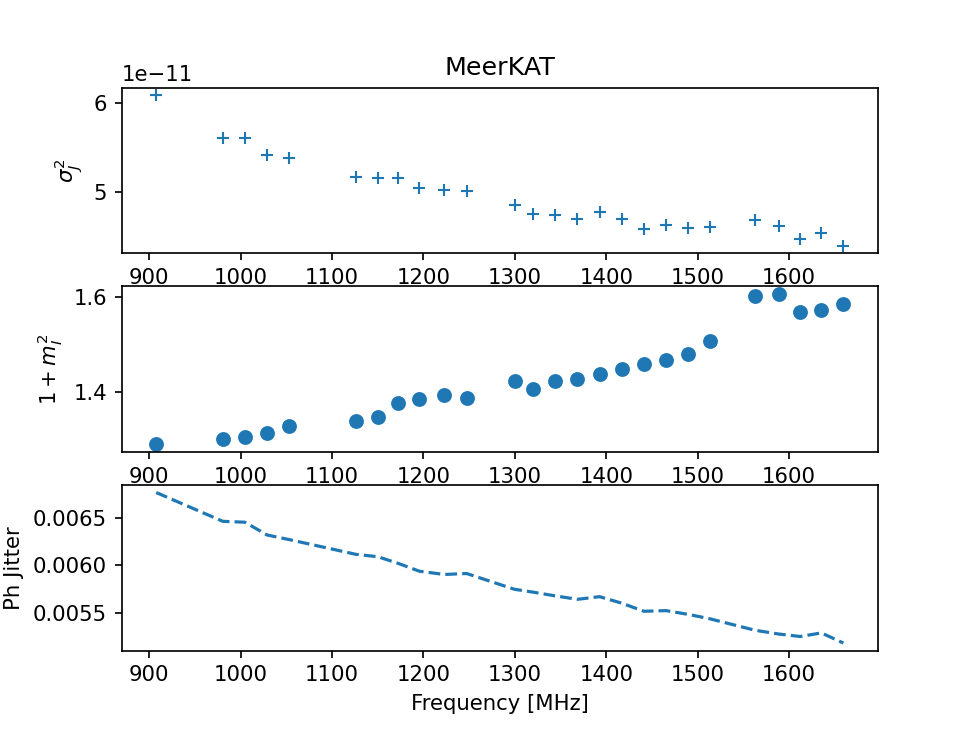

Text(0.5, 0, 'Frequency [MHz]')

In [68]:
if telescope=='Parkes':
    Ni=64
    phi=np.sqrt(var_jitter_32p_Entire_rm*Ni)/(P*np.sqrt(1+np.array(mod_index_Energies)**2))
if telescope=='MeerKAT':
    Ni=32
    phi=np.sqrt(var_jitter_32p_Entire_rm*Ni)/(P*np.sqrt(1+np.array(mod_index_Energies)**2))


plt.figure()
plt.subplot(3,1,1)
plt.plot(Freq_32p_Entire_rm,(var_jitter_32p_Entire_rm),'+')
plt.ylabel("$\sigma_{J}^2$")
plt.title(telescope)
plt.subplot(3,1,2)
plt.plot(Freq_32p_Entire_rm,1+np.array(mod_index_Energies)**2,'o')
plt.ylabel("$1+m_{I}^2$")
plt.subplot(3,1,3)
plt.plot(Freq_32p_Entire_rm,phi,'--')
plt.ylabel("Ph Jitter")
plt.xlabel("Frequency [MHz]")


<IPython.core.display.Javascript object>


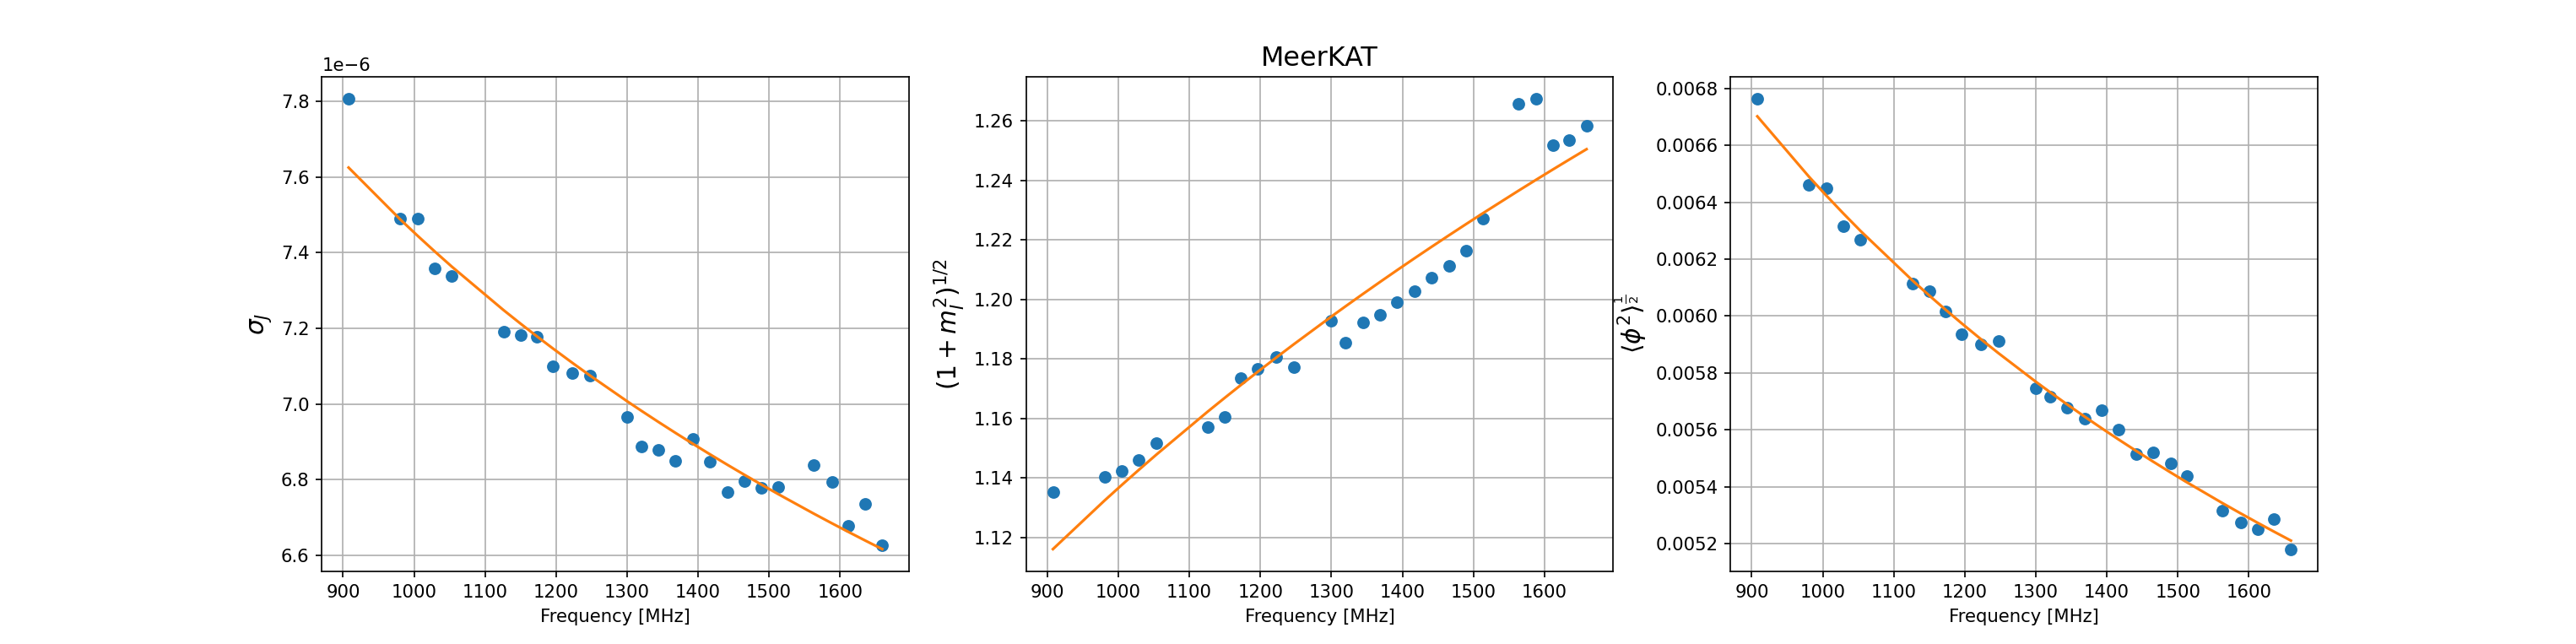

In [97]:

plt.figure(figsize=(20, 5))#, dpi=80)
plt.subplot(1,3,1)
plt.plot(Freq_32p_Entire_rm,np.sqrt(var_jitter_32p_Entire_rm),'o')
plt.plot(Freq_32p_Entire_rm,3.778892991346261e-05*Freq_32p_Entire_rm**-0.23500480681449254 + 0,label='MeerKAT')
plt.ylabel("$\sigma_{J}$",size=14)
plt.xlabel("Frequency [MHz]")
plt.grid()
plt.subplot(1,3,2)
plt.plot(Freq_32p_Entire_rm,np.sqrt(1+np.array(mod_index_Energies)**2),'o')
plt.plot(Freq_32p_Entire_rm,0.3092624737191507*Freq_32p_Entire_rm**0.18843764287616693)
plt.ylabel(r'$(1+m_{I}^2)^{1/2}$',size=14)
plt.grid()
plt.title(telescope,size=15)
plt.xlabel("Frequency [MHz]")
plt.subplot(1,3,3)
plt.plot(Freq_32p_Entire_rm,phi,'o')
plt.plot(Freq_32p_Entire_rm,0.11535656639973624*Freq_32p_Entire_rm**-0.4177766571250041)
plt.ylabel(r'$\langle \phi^2 \rangle^{\frac{1}{2}}$',size=14)
plt.xlabel("Frequency [MHz]")
plt.grid()
plt.savefig('MeerKAT_fit.png')#,dpi=figure)

In [69]:
if telescope=='MeerKAT':
    Freq_32p_Entire_rm_MeerKAT=Freq_32p_Entire_rm.copy()
    var_jitter_32p_Entire_rm_MeerKAT=var_jitter_32p_Entire_rm.copy()
    mod_index_Energies_MeerKAT=np.array(mod_index_Energies)
    phi_MeerKAT=phi.copy()
if telescope=='Parkes':
    Freq_32p_Entire_rm_Parkes=Freq_32p_Entire_rm.copy()
    var_jitter_32p_Entire_rm_Parkes=var_jitter_32p_Entire_rm.copy()
    mod_index_Energies_Parkes=np.array(mod_index_Energies)
    phi_Parkes=phi.copy()

<IPython.core.display.Javascript object>


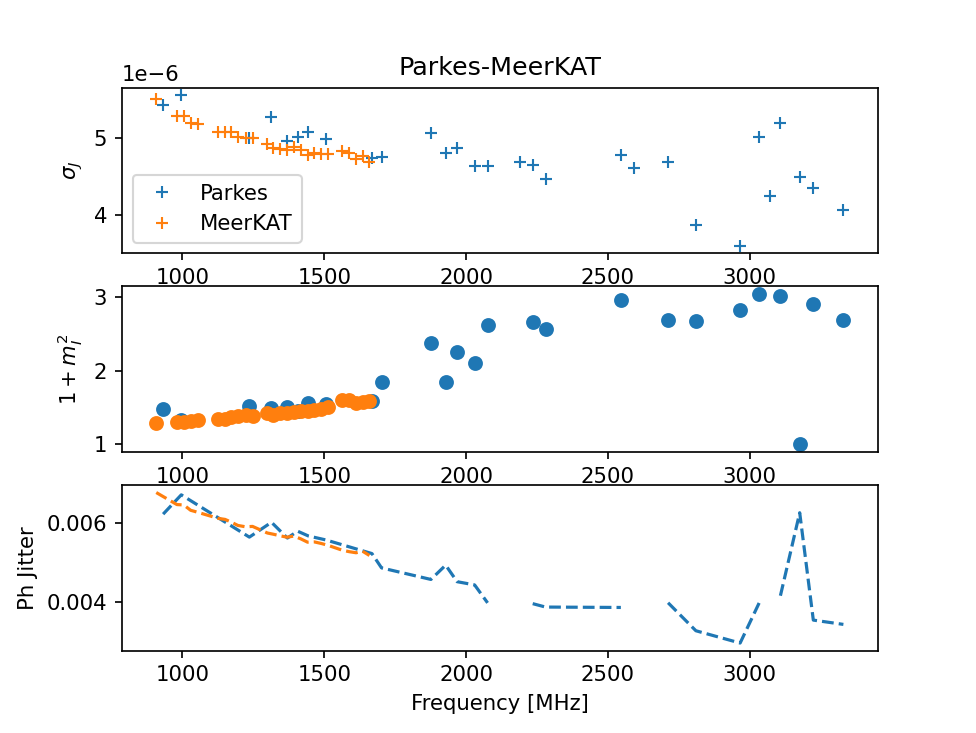

Text(0.5, 0, 'Frequency [MHz]')

In [70]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(Freq_32p_Entire_rm_Parkes,np.sqrt(var_jitter_32p_Entire_rm_Parkes),'+',label='Parkes')
plt.plot(Freq_32p_Entire_rm_MeerKAT,np.sqrt(var_jitter_32p_Entire_rm_MeerKAT/2),'+',label='MeerKAT')
plt.legend()
plt.ylabel("$\sigma_{J}$")
plt.title('Parkes-MeerKAT')
plt.subplot(3,1,2)
plt.plot(Freq_32p_Entire_rm_Parkes,1+mod_index_Energies_Parkes**2,'o')
plt.plot(Freq_32p_Entire_rm_MeerKAT,1+mod_index_Energies_MeerKAT**2,'o')
plt.ylabel("$1+m_{I}^2$")
plt.subplot(3,1,3)
plt.plot(Freq_32p_Entire_rm_Parkes,phi_Parkes,'--')
plt.plot(Freq_32p_Entire_rm_MeerKAT,phi_MeerKAT,'--')
plt.ylabel("Ph Jitter")
plt.xlabel("Frequency [MHz]")


### Fitting power law to
1. Variance of jitter
2. Modulation index of pulses
3. Phase jitter 


#### Variance of Jitter

In [216]:
import lmfit as lm


def get_residuals(params,f,data):
    a=params['a'].value
    alpha=params['alpha'].value
    b=params['b'].value
    
    model= a*f**alpha + b
  
    return data-model


params=lm.Parameters()
params.add('a',value=0)
params.add('alpha',value=0)
params.add('b',value=0,min=0)

result = lm.minimize(get_residuals,params,args=(Freq_32p_Entire_rm_MeerKAT,(var_jitter_32p_Entire_rm_MeerKAT/2)))


In [217]:
result

In [218]:
result.params

name,value,initial value,min,max,vary
a,2.4657e-11,0,-inf,inf,True
alpha,-2.5145e-10,0,-inf,inf,True
b,0.00000000,0,0.00000000,inf,True


<IPython.core.display.Javascript object>


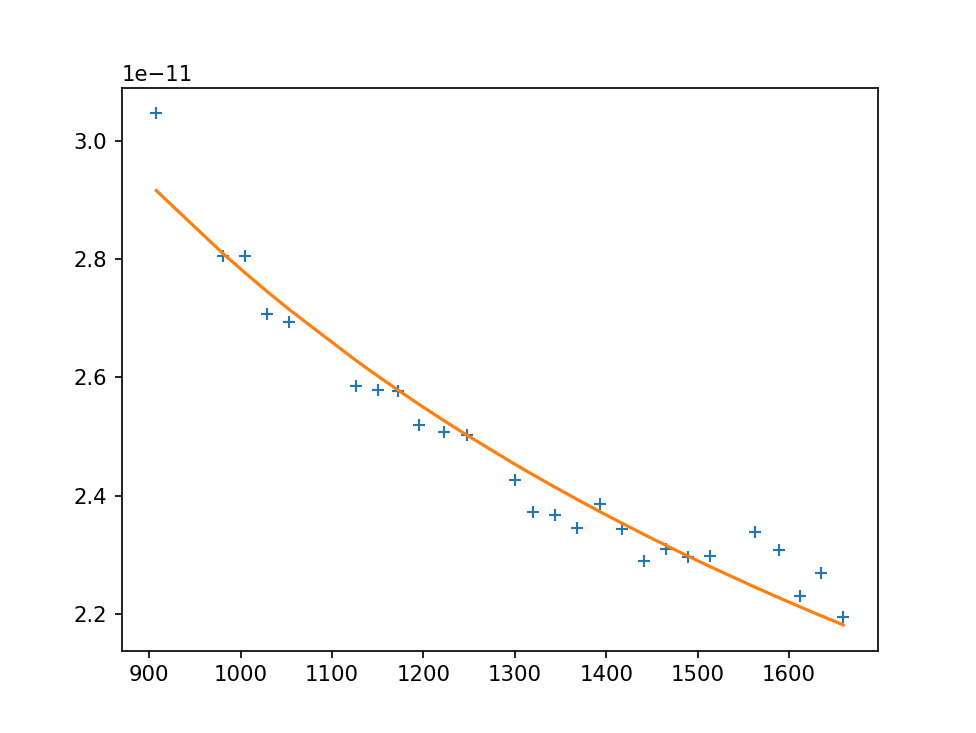

In [219]:
plt.figure()
plt.plot(Freq_32p_Entire_rm_MeerKAT,(var_jitter_32p_Entire_rm_MeerKAT/2),'+',label='MeerKAT')
#plt.plot(Freq_32p_Entire_rm_MeerKAT,result.params['a']*Freq_32p_Entire_rm_MeerKAT**result.params['alpha'] + result.params['b'],label='MeerKAT')
plt.plot(Freq_32p_Entire_rm_MeerKAT,7.712395166947772e-10*Freq_32p_Entire_rm_MeerKAT**-0.48088680319857957 + 0,label='MeerKAT')

In [220]:
params_fitted=result.params

In [221]:
a_linspace=np.linspace(-1e-7,1e-7,500)
alpha_linspace=np.linspace(-0.5,0.5,num=500)
chisq = np.empty([a_linspace.shape[0],alpha_linspace.shape[0]])
acount,alpcount=0,0
for a in a_linspace:
    for alp in alpha_linspace:
        params_fitted['alpha'].value=alp
        params_fitted['a'].value=a
        chisq[acount,alpcount]=np.log10(sum(get_residuals(params_fitted,Freq_32p_Entire_rm_MeerKAT,(var_jitter_32p_Entire_rm_MeerKAT/2))**2))
        alpcount+=1
    alpcount=0
    acount+=1

<IPython.core.display.Javascript object>


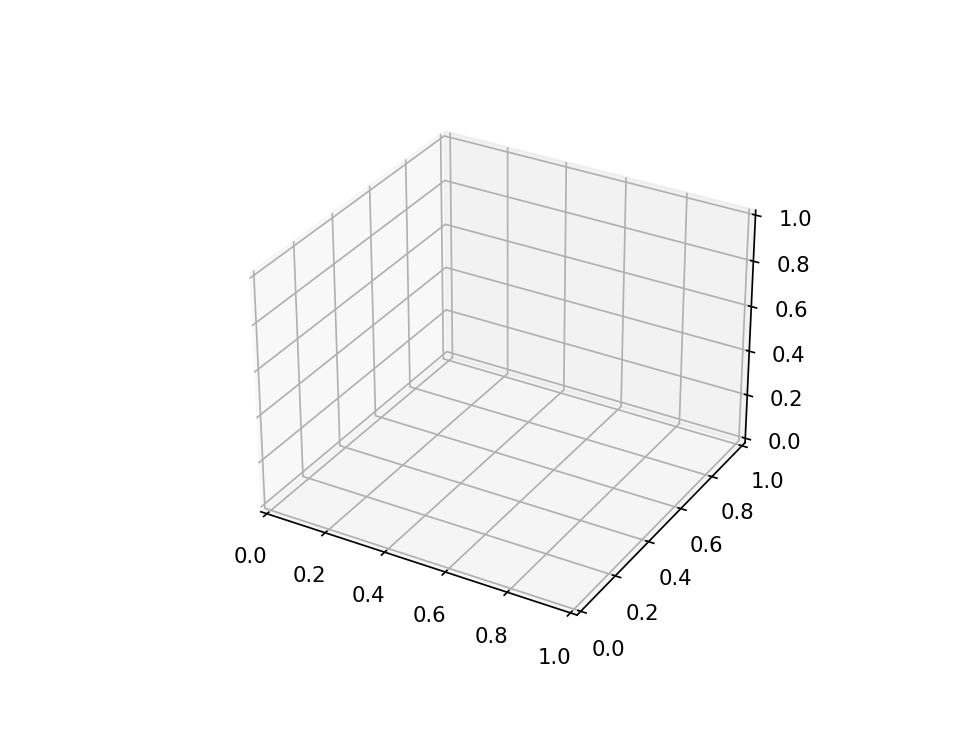

AttributeError: 'Axes3DSubplot' object has no attribute 'wireframe'

In [222]:
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(a_linspace, alpha_linspace)  # `plot_surface` expects `x` and `y` data to be 2D
#ha.plot_surface(X, Y,chisq,cmap='cool')
ha.wireframe(X, Y,chisq)
#ha.scatter3D(fitted['a'],fitted['alpha'],np.log10(result.chisqr),s=10)
ha.view_init(30,215)

It can be seen from the Chi-square plot above that there is a series of local minimums near alpha=-0.205 where as the lowest value of chi square obtained by lm-fit is near -2.305... This make us doubt about the accepting whether the true value is really -2.305 or not

### Using Bilby to perform the fit using Gaussian likelihood 

In [55]:
import bilby

def powerlaw(f,a,alpha):#,b):
    return a*f**alpha# + b

In [ ]:
outdir=os.path.join('/home/akulkarn/notebooks/bilby_result_variance_fit/', telescope)

likelihood=bilby.likelihood.GaussianLikelihood(Freq_32p_Entire_rm_MeerKAT,np.sqrt(var_jitter_32p_Entire_rm_MeerKAT),powerlaw)
priors=dict()
priors["a"]=bilby.core.prior.Uniform(-1,1,"a")
priors["alpha"]=bilby.core.prior.Uniform(-5,5,"alpha")
#priors["b"]=bilby.core.prior.Uniform(0,1e-4,"b")
priors["sigma"]=bilby.core.prior.Uniform(0,1e-5,"sigma")

result_blb = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=250,
        outdir=outdir,
        clean=True
    )
result_blb.plot_corner()

In [ ]:
print("a is",result_blb.get_one_dimensional_median_and_error_bar("a").median)
print("alpha is",result_blb.get_one_dimensional_median_and_error_bar("alpha").median)

In [ ]:
print("a is",result_blb.get_one_dimensional_median_and_error_bar("a").median)
print("alpha is",result_blb.get_one_dimensional_median_and_error_bar("alpha").median)

<IPython.core.display.Javascript object>


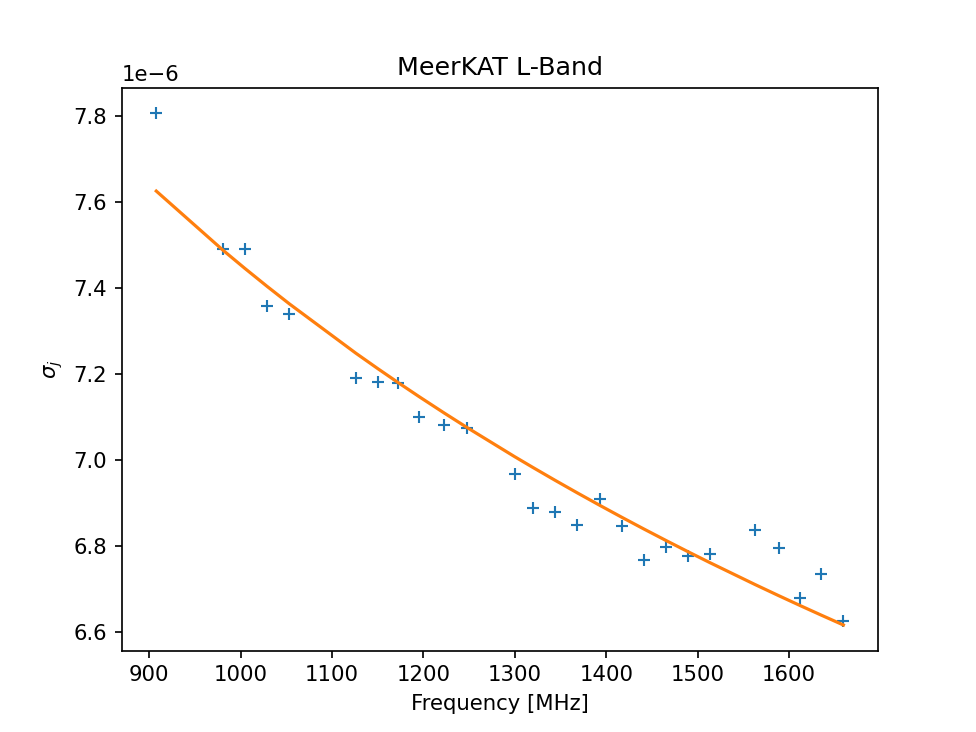

Text(0.5, 1.0, 'MeerKAT L-Band')

In [94]:
plt.figure()
#plt.plot(Freq_32p_Entire_rm_Parkes,np.sqrt(var_jitter_32p_Entire_rm_Parkes),'+',label='MeerKAT')
plt.plot(Freq_32p_Entire_rm_MeerKAT,np.sqrt(var_jitter_32p_Entire_rm_MeerKAT),'+',label='MeerKAT')
plt.plot(Freq_32p_Entire_rm_MeerKAT,3.778892991346261e-05*Freq_32p_Entire_rm_MeerKAT**-0.23500480681449254 + 0,label='MeerKAT')
#plt.plot(Freq_32p_Entire_rm_Parkes,(1.9805315963239423e-05)*Freq_32p_Entire_rm_Parkes**(-0.1880570501993324) + 0,label='MeerKAT')
#plt.plot(Freq_32p_Entire_rm_Parkes,np.sqrt(3.991387220736442e-10)*Freq_32p_Entire_rm_Parkes**(-0.3775894306994969/2) + 0,label='MeerKAT')
#plt.plot(Freq_32p_Entire_rm_Parkes,7.712395166947772e-10*Freq_32p_Entire_rm_Parkes**-0.48088680319857957 + 0,label='MeerKAT')
plt.xlabel("Frequency [MHz]")
plt.ylabel(r'$\sigma_{j}$')
plt.title("MeerKAT L-Band")

### Fitting for $1 + m_{I}^2$ using bilby

In [233]:
def powerlaw_withConst(f,a,alpha,b):
    return a*f**alpha + b

telescope='Parkes'
outdir=os.path.join('/home/akulkarn/notebooks/bilby_result_modIndex_fit/', telescope)

likelihood=bilby.likelihood.GaussianLikelihood(Freq_32p_Entire_rm_Parkes,np.sqrt(1+mod_index_Energies_Parkes**2),powerlaw)
priors=dict()
priors["a"]=bilby.core.prior.Uniform(-1,1,"a")
priors["alpha"]=bilby.core.prior.Uniform(-5,5,"alpha")
#priors["b"]=bilby.core.prior.Uniform(0,1e-2,"b")
priors["sigma"]=bilby.core.prior.Uniform(0,1,"sigma")

result_blb = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=250,
        outdir=outdir,
        clean=True
    )
result_blb.plot_corner()

22:31 bilby INFO    : Running for label 'label', output will be saved to '/home/akulkarn/notebooks/bilby_result_modIndex_fit/Parkes'
22:31 bilby INFO    : Search parameters:
22:31 bilby INFO    :   a = Uniform(minimum=-1, maximum=1, name='a', latex_label='a', unit=None, boundary=None)
22:31 bilby INFO    :   alpha = Uniform(minimum=-5, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None)
22:31 bilby INFO    :   sigma = Uniform(minimum=0, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
22:31 bilby INFO    : Single likelihood evaluation took 6.094e-05 s


0it [00:00, ?it/s]

22:31 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'print_progress': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7faf4c62c520>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
22:31 bilby INFO    : Checkpoint every check_point_delta_t = 600s
22:31 bilby INFO    : Using dynesty version 1.0.1
22:31 bilby INFO    : Using the bilby-implemented rw

SystemExit: 130

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [226]:
print("a is",result_blb.get_one_dimensional_median_and_error_bar("a").median)
print("alpha is",result_blb.get_one_dimensional_median_and_error_bar("alpha").median)

a is 0.3092624737191507
alpha is 0.18843764287616693


<IPython.core.display.Javascript object>


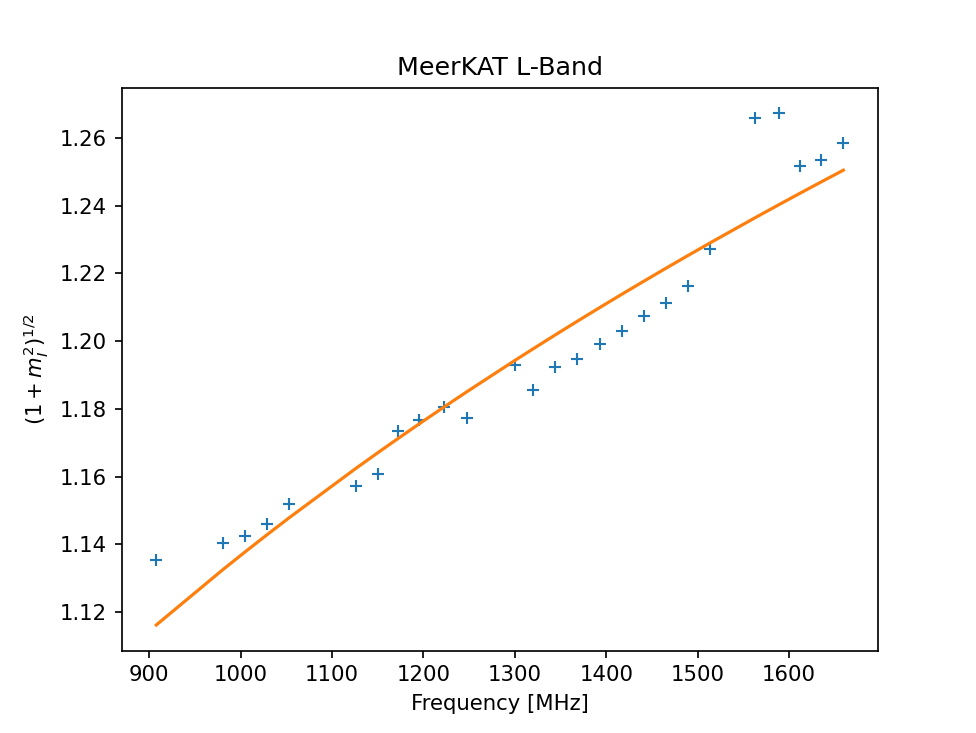

Text(0.5, 1.0, 'MeerKAT L-Band')

In [232]:
plt.figure()
plt.plot(Freq_32p_Entire_rm_MeerKAT,np.sqrt(1+mod_index_Energies_MeerKAT**2),'+')
plt.plot(Freq_32p_Entire_rm_MeerKAT,0.3092624737191507*Freq_32p_Entire_rm_MeerKAT**0.18843764287616693)
plt.xlabel("Frequency [MHz]")
plt.ylabel(r'$(1+m_{I}^2)^{1/2}$')
plt.title("MeerKAT L-Band")

<IPython.core.display.Javascript object>


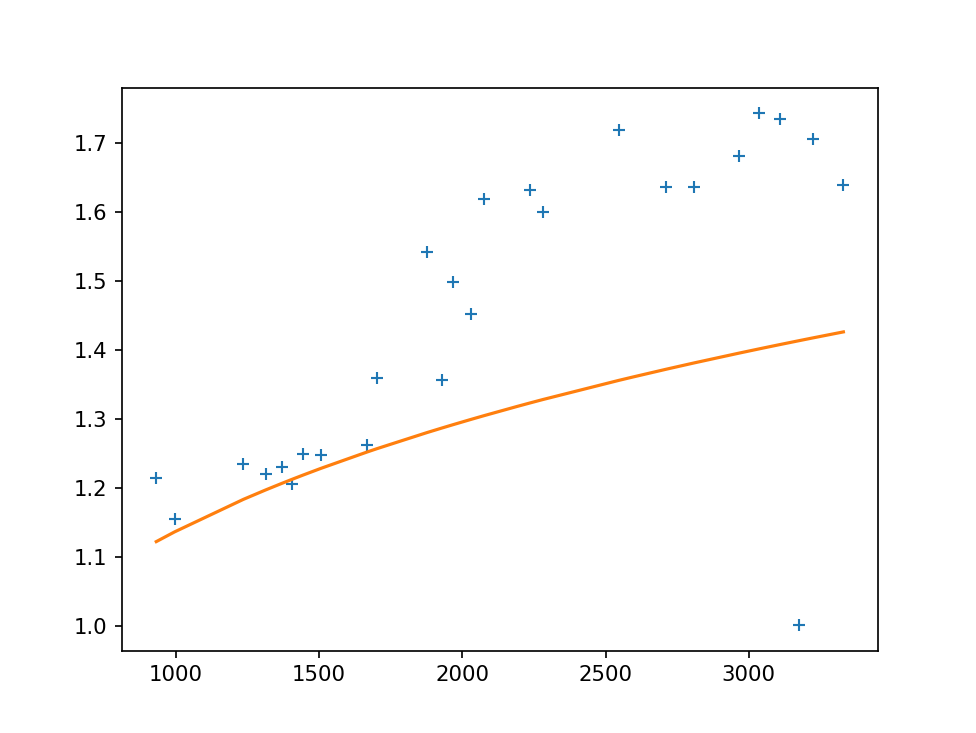

In [52]:
plt.figure()
plt.plot(Freq_32p_Entire_rm_Parkes,np.sqrt(1+mod_index_Energies_Parkes**2),'+')
plt.plot(Freq_32p_Entire_rm_Parkes,0.3092624737191507*Freq_32p_Entire_rm_Parkes**0.18843764287616693)

### Fitting for phase jitter using bilby

In [56]:
telescope='Parkes'
outdir=os.path.join('/home/akulkarn/notebooks/bilby_result_phaseJitter_fit/', telescope)

likelihood=bilby.likelihood.GaussianLikelihood(Freq_32p_Entire_rm_Parkes,phi_Parkes,powerlaw)
priors=dict()
priors["a"]=bilby.core.prior.Uniform(-1,1,"a")
priors["alpha"]=bilby.core.prior.Uniform(-5,5,"alpha")
#priors["b"]=bilby.core.prior.Uniform(0,1e-2,"b")
priors["sigma"]=bilby.core.prior.Uniform(0,1,"sigma")

result_blb = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=250,
        outdir=outdir,
        clean=True
    )
result_blb.plot_corner()

11:40 bilby INFO    : Running for label 'label', output will be saved to '/home/akulkarn/notebooks/bilby_result_phaseJitter_fit/Parkes'
11:40 bilby INFO    : Search parameters:
11:40 bilby INFO    :   a = Uniform(minimum=-1, maximum=1, name='a', latex_label='a', unit=None, boundary=None)
11:40 bilby INFO    :   alpha = Uniform(minimum=-5, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None)
11:40 bilby INFO    :   sigma = Uniform(minimum=0, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
11:40 bilby INFO    : Single likelihood evaluation took 7.656e-05 s


0it [00:00, ?it/s]

11:40 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'print_progress': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fab6e18ee50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
11:40 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:40 bilby INFO    : Using dynesty version 1.0.1
11:40 bilby INFO    : Using the bilby-implemented rw

SystemExit: 130

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [235]:
print("a is",result_blb.get_one_dimensional_median_and_error_bar("a").median)
print("alpha is",result_blb.get_one_dimensional_median_and_error_bar("alpha").median)

a is 0.11535656639973624
alpha is -0.4177766571250041


<IPython.core.display.Javascript object>


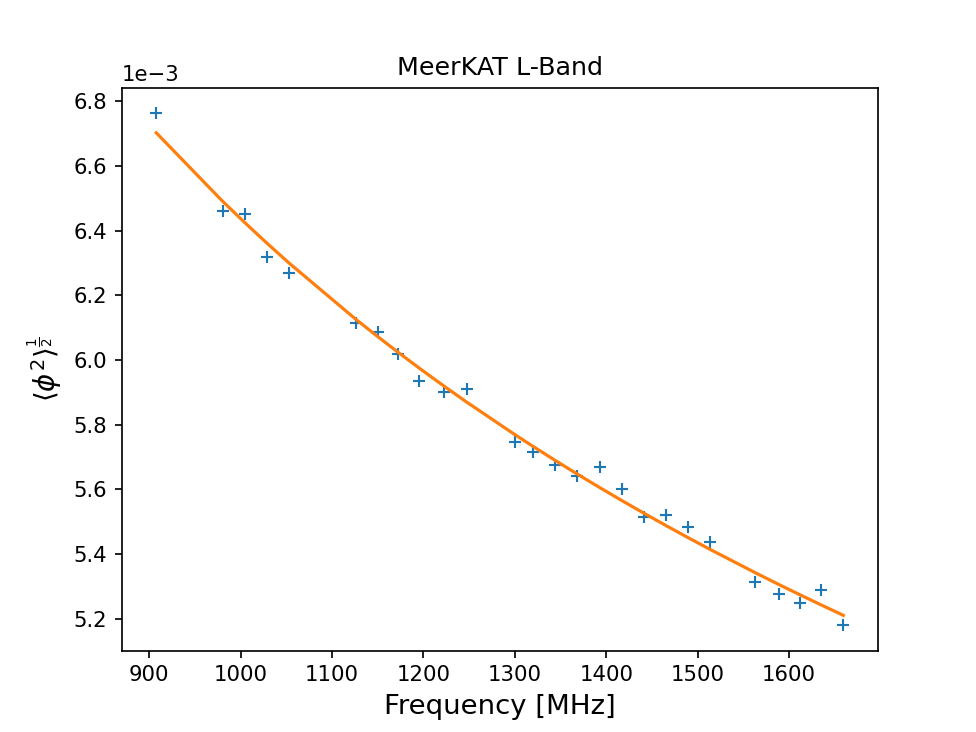

Text(0.5, 1.0, 'MeerKAT L-Band')

In [53]:
plt.figure()
plt.plot(Freq_32p_Entire_rm_MeerKAT,phi_MeerKAT,'+')
plt.plot(Freq_32p_Entire_rm_MeerKAT,0.11535656639973624*Freq_32p_Entire_rm_MeerKAT**-0.4177766571250041)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel("Frequency [MHz]",size=13)
plt.ylabel(r'$\langle \phi^2 \rangle^{\frac{1}{2}}$',size=13)
plt.title("MeerKAT L-Band")